In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("../../../FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 5  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 6  | Account from offset between diffuse focus        | <input type="checkbox">  |      Done by Zeren                       |
| 7  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 8  | Add CNES moves to google drive     | <input type="checkbox">  |                             |
| 9  | Take into account diff OS vs no OS = 1088    | <input type="checkbox">  |                             |

In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
Elg = 0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg = 1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09171 ''/inc and Ce is 0.01018 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "QSO"
previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F3_nogamma.new.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-2023-0-QSO_10125.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# # load model from previous XY calib
# G2UV = Guider2UV(filename=previous_xy_mapping)

# # eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
# G2UV.mask_rotation = 0.0*u.arcmin
# G2UV.FieldP.gamma = 1.
# G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# print(G2UV)

# # if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# #G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
# #                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
# #                                                    frame = G2UV.GuiderP.localframe)

# # load targets
# F1 = Table.read(target_filename, format='ascii')

# # load mask-UVdetector mappings
# mask_det_map = Mapping(mask_det_map_file)

# # if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     # raise ValueError("Please verify the initialization mapping")



## Alternative initialisation for new fields:
---------------------------------------

In [5]:
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)
f_ra, f_dec, f_rot = 0.038940, 1.394590, 90-100
Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# get FOVcenter & guider wcs from another field
#  put pkl from a functionning mapping from another field
G2UVother = Guider2UV(filename=previous_xy_mapping)
FOVcenter = G2UVother.FOV_center_guider_coord
guider_wcs = G2UVother.GuiderP.w
G2UV = Guider2UV(Field_center=Field_center,
                 Field_rotation= f_rot * u.deg,
                 Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
                 FOVcenter_guider_coord=FOVcenter,
                 guider_wcs = guider_wcs,
                 )



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.18212015, -0.00658703)>
FOV center pixel position in guider [array(1356.48459465), array(515.54397687)]


## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [ ]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([1.8, -103.7])
diffuse_offset = np.array([0,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus
## 4 - Align siderostat frames
## 5 - Go to guider reference
## 6 - Set UV/guider best focus offset
## 7 - Rotate mask carousel
## 8 - Through focus in UV
## 9 - Note open-mask guider ref point


## 10 - Go through the list of slits


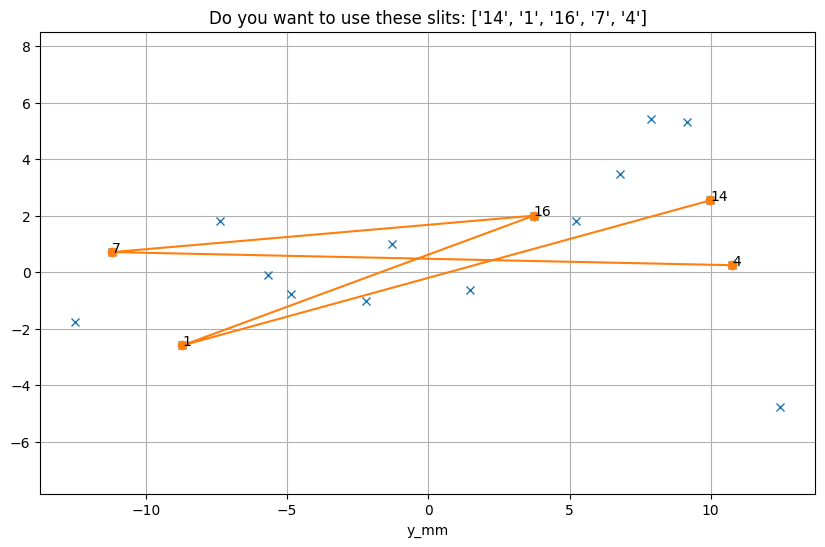

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
14,9.978798853783994,2.541725765588142,0.26145999999999997,1.4949700000000001,-1264556.2446597973,12282.283656,1264615.8904584013
1,-8.71595571546094,-2.5953305828987903,351.646688302,-1.91677546,1212301.7976884702,-7141.987656,1212322.8351665966
16,3.734748022927276,2.000933456045201,14.70766,0.06711,1235.3391526054388,329.32800000000003,1278.4833802376643
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,50672.04741642562,-5288.256,50947.24762824801
4,10.74985226874078,0.24703836059371156,0.28894000000000003,1.44459,0.0,0.0,0.0


In [ ]:
# slits = ['46', '35', '12', '38"] #F1
# slits =['3', '22','11', '20', '16', '18', '10', '5',"0"] #F2
# slits = ['4', '13', '22', '12', '6', '23', "5", "18", "3"] # F3 with 206 #20 can not be reached
# slits = ['OVI14', '36', '4', 'QSO1', 'LyC7', '11',"7"] #F4
# slits = ['17', '6', '14', '1', '16', '7',"10","0","16"] #QSO

slits =[ '14', '1', '16', '7',"4"]#,"0","16"]#'17', '6',

slits =[ '14', '9', '16', '7',"3"]#,"0","16"]#'17', '6',


F1['Internal-count'] = F1['Internal-count'].astype(str)


F1['Internal-count'] = F1['Internal-count'].astype(str)
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.axis('equal')
plt.grid()
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [ ]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [9.97879885 2.54172577]
slit position in mm on mask: [-8.71595572 -2.59533058]
slit position in mm on mask: [3.73474802 2.00093346]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [10.74985227  0.24703836]

targets local coords in siderostat local frame:
EL: 434.6 arcsec ; CE: 425.1 arcsec
EL: 216.3 arcsec ; CE: -349.6 arcsec
EL: 411.5 arcsec ; CE: 166.1 arcsec
EL: 356.8 arcsec ; CE: -452.7 arcsec
EL: 337.1 arcsec ; CE: 457.1 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=337.0790 and CE=457.1288


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [ ]:

slits_coord_obs_det = np.array([
[ 663.4	,257.2 ],
[ 328.7	,1697.2 ],
[ 624.5	,737.6 ],
[ 556.3	,1884.1  ],
[ 510	,198.1 ],
# [ 1717.4,	1992.6  ],
# [ 1590.5,	1316.6  ],
# [ 1553.5,	1854.4  ],
# [ 1791.4,	866.5  ]
])


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.2391996, -0.23194753)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.10915613, 0.21261566)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.22431832, -0.08590986)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.18607494, 0.26828519)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.1905398, -0.25881171)]>]

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

In [ ]:
slits_coord_obs_det, obs_wave, weight

(array([[ 663.4,  257.2],
        [ 328.7, 1697.2],
        [ 624.5,  737.6],
        [ 556.3, 1884.1],
        [ 510. ,  198.1]]),
 0.20619,
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.90909091, 0.90909091, 0.90909091, 0.90909091,
        0.90909091, 0.90909091, 0.90909091, 0.90909091, 0.90909091,
        0.90909091, 0.90909091, 0.90909091, 0.90909091, 0.90909091,
        0.90909091, 0.90909091]))

Fitting rotation, translation and magnification
gamma: 0.989985517805829
theta: -79.81500415301875 arcmin
dx: 31.111409191396774 arcsec
dy: -17.005291923919685 arcsec
variances: [5.57268462e-04 1.91574786e+00 5.98012519e-01 5.98012519e-01]

residuals in arcsec: [[ -9.31875218  11.59874161]
 [  2.15767286  11.44677083]
 [ -3.68164987  -0.09539126]
 [ -0.87398751  -8.96221308]
 [ 11.7167167  -13.98790809]]
max residual in EL,CE 11.7, 14.0 arcsec
mean residual in EL,CE 7.0, 10.4 arcsec


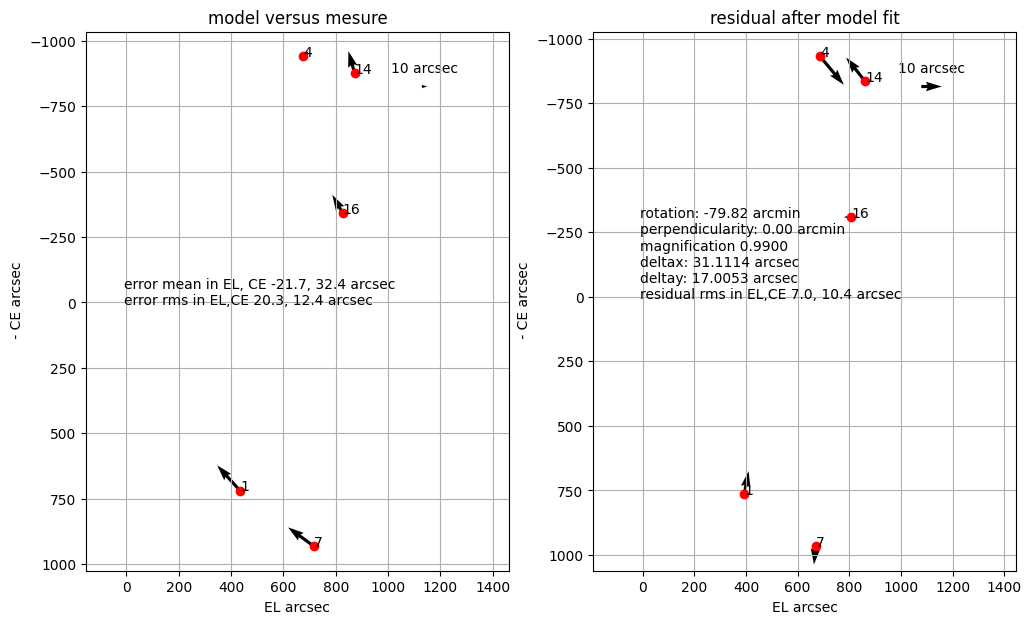

After updating:
    mask_rotation: -1.3302500692169792 deg
    FOV center in guider: 1381.7030610198115 x 481.19762935620315 pix = 679.6275632415017 arcsec x -55.70310278440621 arcsec arcsec
    mask_magnification correction: 0.989985517805829  
    


In [ ]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits)


### check updating without fitting magnification

In [ ]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (0.03894, 1.39459)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 0.0 deg
    FOV center in guider: 1356.4845946522387x515.5439768745559 pix



Fitting rotation, translation and magnification
gamma: 0.989985517805829
theta: -79.81500415301875 arcmin
dx: 31.111409191396774 arcsec
dy: -17.005291923919685 arcsec
variances: [5.57268462e-04 1.91574786e+00 5.98012519e-01 5.98012519e-01]

residuals in arcsec: [[ -9.31875218  11.59874161]
 [  2.15767286  11.44677083]
 [ -3.68164987  -0.09539126]
 [ -0.87398751  -8.96221308]
 [ 11.7167167  -13.98790809]]
max residual in EL,CE 11.7, 14.0 arcsec
mean residual in EL,CE 7.0, 10.4 arcsec


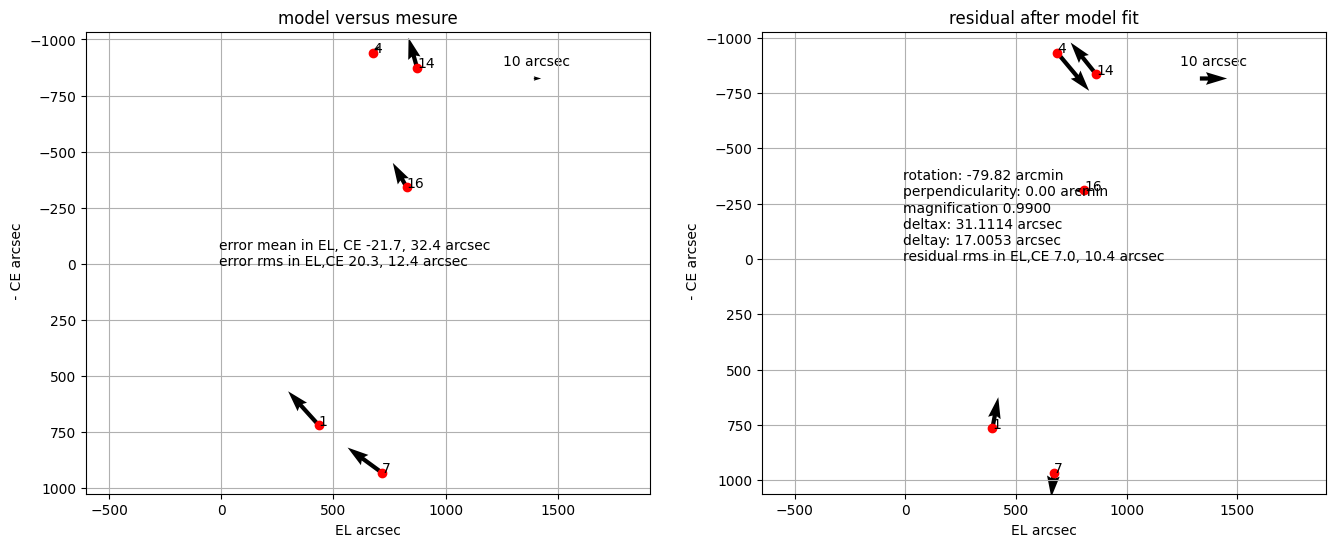

After updating:
    mask_rotation: -1.3302500692169792 deg
    FOV center in guider: 1381.7030610198115 x 481.19762935620315 pix = 679.6275632415017 arcsec x -55.70310278440621 arcsec arcsec
    mask_magnification correction: 0.989985517805829  
    


In [ ]:
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True)


### save corrected model for future use (eg redo the calib on same field)

In [ ]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO_XY_230620.pkl")


Dumping to Calibration/Mappings/2023/XY/QSO_XY_230620.pkl


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [ ]:
new_cat

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
14,9.978798853783994,2.541725765588142,0.26145999999999997,1.4949700000000001,-1264556.2446597973,12282.283656,1264615.8904584013,-199.20440566991005,-780.3949535286572,-397.17374402466663,-1588.8841253843461,1637.7728007391472,0.0012950752976427357,-0.03233712517546718,0.001256475646768723
1,-8.71595571546094,-2.5953305828987903,351.646688302,-1.91677546,1212301.7976884702,-7141.987656,1212322.8351665966,182.32824541429457,520.6242193728577,363.52605570702053,1059.9909106431385,1120.5944510945849,0.0009243366689043629,-0.050899843743306035,0.0008743622360902647
16,3.734748022927276,2.000933456045201,14.70766,0.06711,1235.3391526054388,329.32800000000003,1278.4833802376643,-39.84054471122448,-620.5944659514429,-79.43407804523937,-1263.5303326771377,1266.024752660901,0.9902551509316865,-0.2412004993357363,-1.022820599518959
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,50672.04741642562,-5288.256,50947.24762824801,-41.25453696487649,910.2073739350476,-82.25329580057075,1853.1822133317569,1855.0067170981472,0.03641034213729786,0.015553954990184051,0.03657208081809297


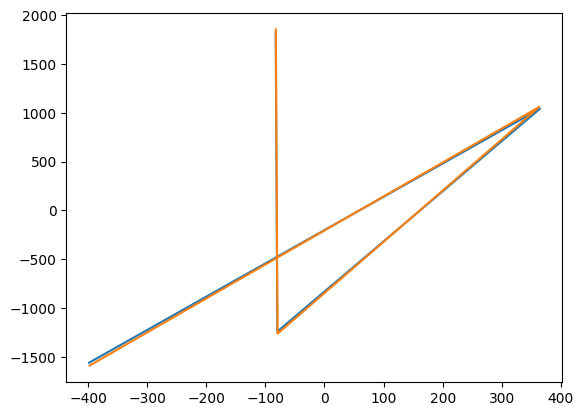

In [ ]:
plt.plot(2*moves["EL"][1:],2*moves["CE"][1:])
plt.plot(new_cat["El_sky"] ,new_cat["Cel_sky"] )

slit position in mm on mask: [9.97879885 2.54172577]
slit position in mm on mask: [-8.71595572 -2.59533058]
slit position in mm on mask: [3.73474802 2.00093346]
slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [10.74985227  0.24703836]

targets local coords in siderostat local frame:
EL: 438.7 arcsec ; CE: 443.8 arcsec
EL: 239.5 arcsec ; CE: -336.6 arcsec
EL: 421.9 arcsec ; CE: 184.0 arcsec
EL: 382.0 arcsec ; CE: -436.6 arcsec
EL: 340.8 arcsec ; CE: 473.6 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


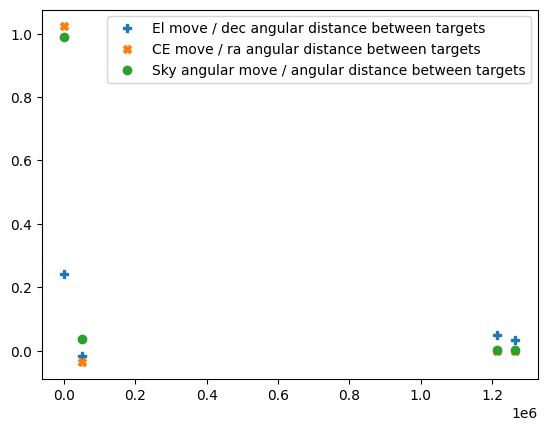

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
14,9.978798853783994,2.541725765588142,0.26145999999999997,1.4949700000000001,-1264556.2446597973,12282.283656,1264615.8904584013,-199.20440566991005,-780.3949535286572,-397.17374402466663,-1588.8841253843461,1637.7728007391472,0.0012950752976427357,-0.03233712517546718,0.001256475646768723
1,-8.71595571546094,-2.5953305828987903,351.646688302,-1.91677546,1212301.7976884702,-7141.987656,1212322.8351665966,182.32824541429457,520.6242193728577,363.52605570702053,1059.9909106431385,1120.5944510945849,0.0009243366689043629,-0.050899843743306035,0.0008743622360902647
16,3.734748022927276,2.000933456045201,14.70766,0.06711,1235.3391526054388,329.32800000000003,1278.4833802376643,-39.84054471122448,-620.5944659514429,-79.43407804523937,-1263.5303326771377,1266.024752660901,0.9902551509316865,-0.2412004993357363,-1.022820599518959
7,-11.196029780247189,0.7110298929269409,14.364510000000001,-0.02437,50672.04741642562,-5288.256,50947.24762824801,-41.25453696487649,910.2073739350476,-82.25329580057075,1853.1822133317569,1855.0067170981472,0.03641034213729786,0.015553954990184051,0.03657208081809297


In [ ]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 16 - Second interation on open mask


wave:  0.20619
Fitting rotation, translation and magnification
gamma: 1.0182001188703464
theta: 52.97178010736053 arcmin
dx: 0.6168435345651587 arcsec
dy: 112.21998700853109 arcsec
variances: [4.95456634e-04 1.70325444e+00 4.50888186e-01 4.50888186e-01]

residuals in arcsec: [[  0.79449709   5.59215839]
 [  1.92690571  -7.39150222]
 [ -4.24445334  -3.24104178]
 [  2.48791815   0.44698258]
 [ -1.49311825   8.63913183]
 [  5.54958886  14.16175441]
 [ -1.71953688  -6.17634674]
 [ -3.30180133 -12.03113647]]
max residual in EL,CE 5.5, 14.2 arcsec
mean residual in EL,CE 3.1, 8.3 arcsec


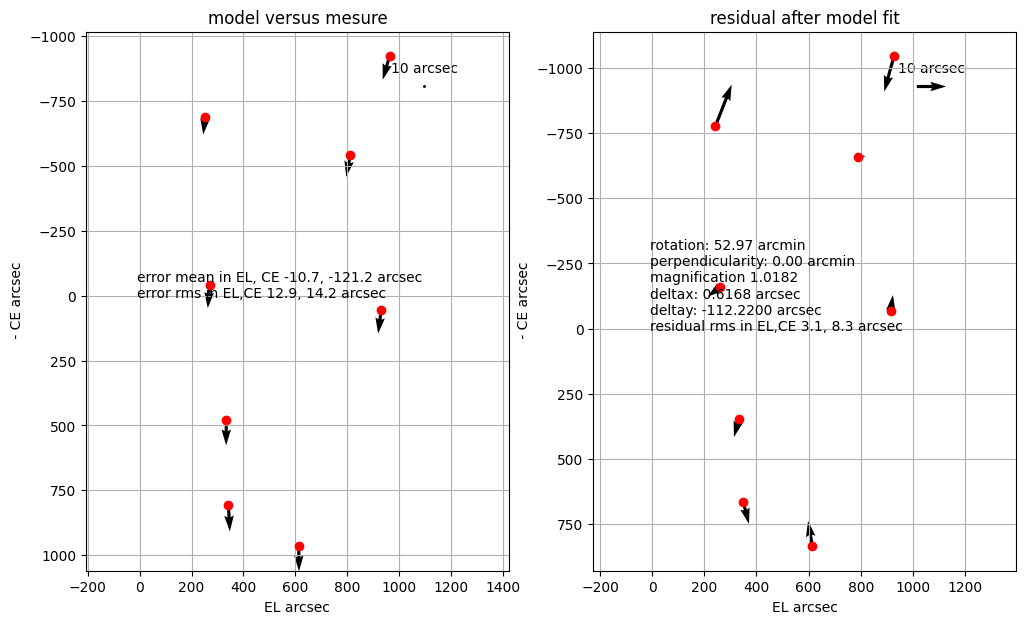

After updating:
    mask_rotation: 52.97178010736053 arcmin
    FOV center in guider: 1360.995572284966 x 516.2712864156649 pix = 659.8809238971849 arcsec x -23.05825511836761 arcsec arcsec
    mask_magnification correction: 1.0182001188703464  
    
slit position in mm on mask: [ 9.60644814 -4.4384782 ]
slit position in mm on mask: [-0.90105352  3.07247507]
slit position in mm on mask: [-9.55164963 -3.55546162]
slit position in mm on mask: [ 0.10439566 -4.49041265]
slit position in mm on mask: [5.92437194 1.6321297 ]
slit position in mm on mask: [-11.34158824  -0.43809484]
slit position in mm on mask: [ 7.50255328 -4.77857585]
slit position in mm on mask: [-5.81725077 -3.69203273]
slit position in mm on mask: [10.29118273  3.31305428]

targets local coords in siderostat local frame:
EL: 144.3 arcsec ; CE: 423.5 arcsec
EL: 464.0 arcsec ; CE: -29.1 arcsec
EL: 169.9 arcsec ; CE: -393.2 arcsec
EL: 135.7 arcsec ; CE: 18.7 arcsec
EL: 405.9 arcsec ; CE: 262.6 arcsec
EL: 304.3 arcsec ; CE: -4

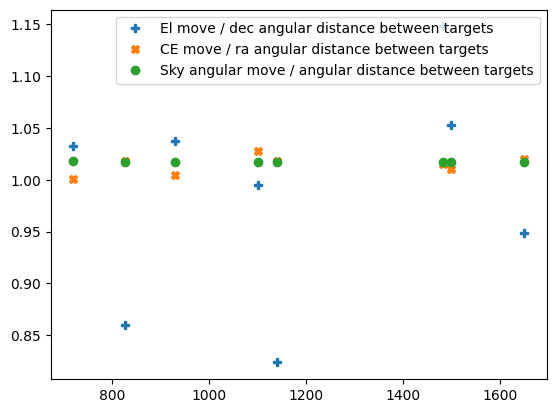

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4,9.606448141617294,-4.438478203336938,352.5700988769531,0.10724475234746933,896.4828045669061,-640.5059605836868,1101.784599832189,319.69928991171287,-452.5551121903909,637.4164442259731,-921.4022084196359,1120.3935706037703,1.0168898446887127,-0.9951764440179476,-1.027796856477095
13,-0.9010535220373401,3.0724750743209586,352.3210754394531,0.2851630747318268,738.1622441627849,565.1210010051727,929.6479142581493,-294.12819937958585,-364.16889843565434,-586.4328039230182,-741.4478772149922,945.3297774552706,1.0168686047229345,-1.0377119287372767,-1.004451098763435
22,-9.551649625200541,-3.555461620393433,352.11602783203125,0.12818501889705658,-823.8333429206866,79.2756680294037,827.6388152143312,-34.19975654781667,411.96599808834463,-68.18747460503687,838.7627721078696,841.5298684937396,1.0167839557836724,-0.8601311890521797,-1.0181219045277465
12,0.10439565884226028,-4.4904126516402565,352.344871,0.106164,-496.06120469011836,-521.7387143417359,719.922221383379,270.24503725750805,243.91485709745152,538.8145552840195,496.61064905041127,732.7641242147344,1.0178379031094202,-1.0327287212409142,-1.0011076140506414
6,5.92437193981131,1.632129696087109,352.482666015625,0.2510914206504822,1472.9727117804312,176.50951434173587,1483.5107745826967,-101.63293220790362,-734.1794379640262,-202.63574023611824,-1494.7893356947573,1508.4616008794567,1.016818769856106,-1.1480159638522376,-1.0148112885865723
23,-11.341588243654323,-0.43809484447039143,352.073503,0.202061,-1607.8889668212646,370.1523632904052,1649.9453632393486,-176.18870087807912,805.6188874258312,-351.28503181071414,1640.2400547989923,1677.435128683448,1.0166610156048614,-0.949028202030177,-1.020120225118333
5,7.5025532792065714,-4.778575854140258,352.5201416015625,0.09924089908599854,1135.7648978547268,-92.82079339027405,1139.551491984701,38.338452710335204,-568.1434303165876,76.43920701386634,-1156.7400241245723,1159.262884673112,1.0172975006632483,-0.8235138294118028,-1.0184678416364725
18,-5.8172507733142735,-3.6920327306593608,352.20465087890625,0.1250244528055191,-1374.113564503511,-597.4471699001313,1498.3761907392352,315.534180869986,681.6288642152883,629.1120498185782,1387.796367542327,1523.732499158107,1.016922524914362,-1.053000301137488,-1.0099575489190078


In [ ]:
slits_coord_obs_det = np.array([
[ 198.4	,261.5 ],
[ 710.6	,1099.1 ],
[ 257.5	,1785.5 ],
[ 187	,1019.6 ],
[ 613.1	,556.5  ],
[ 476	,1930.2   ],
[ 171.9	,428.1  ],
[ 244	,1489.1  ],
[ 727.5	,207.7   ]])

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7))#, labels=slits_valid


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


wave:  0.20619
Fitting rotation, translation and magnification
gamma: 1.0041392237099829
theta: -66.75393956693728 arcmin
dx: 21.465019076598374 arcsec
dy: -117.32017439627245 arcsec
variances: [5.62817880e-04 1.93482535e+00 5.96401432e-01 5.96401432e-01]

residuals in arcsec: [[-3.05805354 -1.13068155]
 [ 1.86666525 -2.36980871]
 [ 1.75489527 10.49623807]
 [-1.16475295 -3.39906632]
 [-0.86793803 -2.11314603]
 [ 1.46918401 -1.48353547]]
max residual in EL,CE 3.1, 10.5 arcsec
mean residual in EL,CE 1.8, 4.7 arcsec


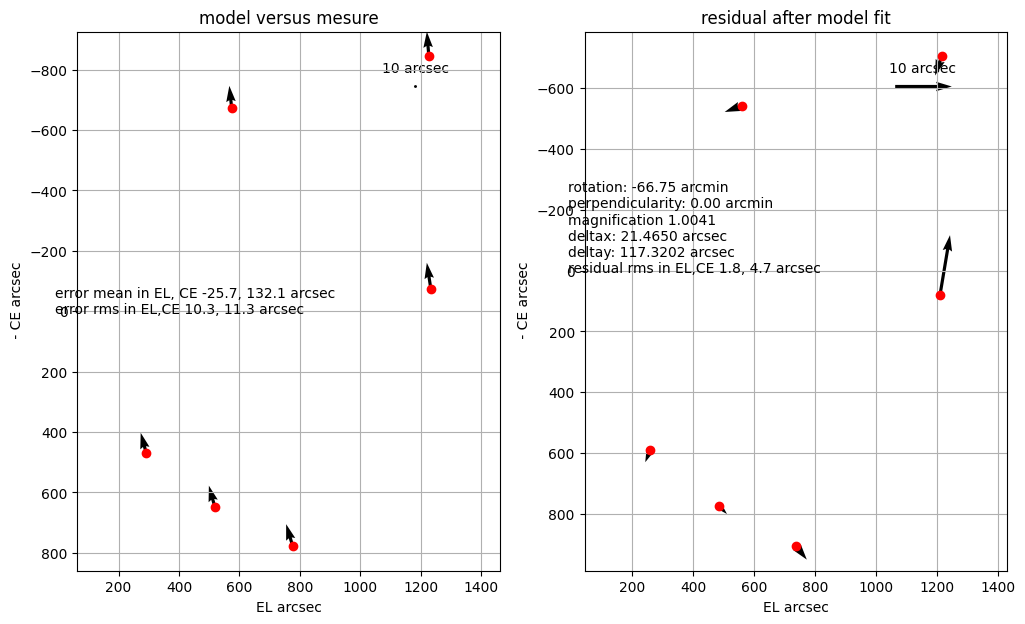

After updating:
    mask_rotation: -66.75393956693728 arcmin
    FOV center in guider: 1404.4924376708336 x 460.1319272060973 pix = 694.6145163857208 arcsec x -63.199262893513605 arcsec arcsec
    mask_magnification correction: 1.0041392237099829  
    
slit position in mm on mask: [10.983847  1.063581]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-9.854999  0.771802]
slit position in mm on mask: [-0.007602  6.3115  ]
slit position in mm on mask: [9.013465 6.404684]
slit position in mm on mask: [-6.155668 -4.825373]
slit position in mm on mask: [-8.28209  -2.212253]

targets local coords in siderostat local frame:
EL: 384.9 arcsec ; CE: 493.4 arcsec
EL: 288.2 arcsec ; CE: 329.8 arcsec
EL: 389.7 arcsec ; CE: -382.4 arcsec
EL: 619.2 arcsec ; CE: 35.9 arcsec
EL: 615.6 arcsec ; CE: 414.9 arcsec
EL: 146.5 arcsec ; CE: -231.5 arcsec
EL: 260.4 arcsec ; CE: -318.7 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spread

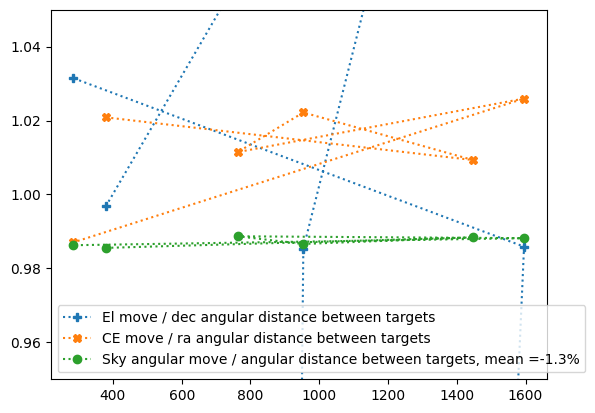

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
OVI14,10.983847,1.063581,37.162998,0.676824,326.14804293402585,193.39919999999978,379.17779005413155,-96.68820211896875,-163.5336303426851,-192.77693738479988,-332.95447137770685,384.7357893384384,1.0146580296370031,-0.996782496436387,-1.0208691377769752
36,7.136533,-1.264856,37.072395,0.623102,1436.6354406838698,-173.39399999999964,1447.0614598782377,101.53041293143258,-712.1901082028081,202.43133730269028,-1450.0190603009173,1464.0811868056057,1.0117615784811242,-1.1674644872526772,-1.0093159469953468
4,-9.854999,0.771802,36.673306,0.671267,-833.0332254840134,-464.3028,953.6883373765977,229.45742085519842,418.2300155492577,457.49220570109463,851.5163116582887,966.6328916902158,1.013573149430794,-0.9853315674622135,-1.0221876938504297
QSO1,-0.007602,6.3115,36.90472,0.80024,-763.035570459838,-8.996400000000104,763.0886036365177,-3.51733580454483,379.0708645837204,-7.012864127101482,771.7882802924547,771.8201408748348,1.0114423635691934,0.7795189328066116,-1.0114709066935659
LyC7,9.013465,6.404684,37.116695,0.802739,1282.8816797461332,948.7799999999999,1595.6092543690827,-469.14854373278155,-646.449976331551,-935.3883664944199,-1316.172151811038,1614.7013746745858,1.0119654108631078,-0.9858854175830224,-1.0259497602861494
11,-6.155668,-4.825373,36.760304,0.539189,179.8804346155643,-220.11839999999992,284.26938065160004,113.87796574318605,-87.20390310715744,227.04988809876434,-177.54714672617257,288.22671804721097,1.0139210821318143,-1.0314898168384126,-0.9870286732718966


In [ ]:
slits_coord_obs_det = np.array([
[ 595.8 + 1072 , 	164.9 ],
[ 431	 + 1072 , 465.1  ],
[ 574	 + 1072 , 1787.6   ],
[ 944.4 + 1072 , 	1022.2   ],
[ 958	 + 1072 , 318.2  ],
[ 190.6 + 1072 , 	1497.7  ],
[ 369.2 + 1072 , 	1663.6   ]])

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7))#, labels=slits_valid


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:6]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],":P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],":X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],1/new_cat["frame_divided_sky"],":o",label="Sky angular move / angular distance between targets, mean =%0.1f%%"%(100*(1/new_cat["frame_divided_sky"].mean()-1)))
plt.legend()
plt.ylim((0.95,1.05))
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"



## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence
[36, 40, 46, 21 ]
we did not have the time to do this because G2UV was not well

In [ ]:
star_target_path = "Calibration/Targets/2022/GuidingStars/%s_guidingstars.fits"%(Field)
# il faut que le centre soit bien defini à l'arcseconde pres.
F1_stars = Table.read(star_target_path, format='fits').to_pandas()

stars =[29, 34, 18, 14 ]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()



# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: -104.4 arcsec ; CE: 169.0 arcsec
EL: -127.2 arcsec ; CE: 233.2 arcsec
EL: 134.3 arcsec ; CE: -20.8 arcsec
EL: 61.5 arcsec ; CE: -39.9 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [ ]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
29,36.987137,0.402799,3.499382,-10.623502,10,--,--,375.60643978519715,274.037723163956
34,37.023638,0.390844,5.052622,-11.132199,9,--,--,329.09823563737774,119.62777354437654
18,36.877561,0.53311,-1.163312,-5.078307,--,12,11,905.7629054456784,724.3865249427333
14,36.867454,0.492628,-1.593376,-6.800959,--,13,12,743.471574722354,767.263365496059
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)
## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------